## Load data

In [1]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd

data = pd.read_csv(r"extdata/noisy_sbc_500.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [2]:
import torch

y_train = torch.tensor(data_analysis.get_y_train(), dtype=torch.long)
X_train = torch.tensor(data_analysis.get_X_train(), dtype=torch.float)

y_test = torch.tensor(data_analysis.get_y_test(), dtype=torch.long)
X_test = torch.tensor(data_analysis.get_X_test(), dtype=torch.float)

y_gw_test = torch.tensor(data_analysis.get_y_gw(), dtype=torch.long)
X_gw_test = torch.tensor(data_analysis.get_X_gw(), dtype=torch.float)

In [3]:
y_all = torch.concat((y_train, y_test, y_gw_test))
X_all = torch.concat((X_train, X_test, X_gw_test))

## Train/Validation/Test splits

In [4]:
def true_indices_like(tensor):
    return torch.ones((tensor.shape[0])).type(torch.bool)

def false_indices_like(tensor):
    return torch.zeros((tensor.shape[0])).type(torch.bool)

def split(train_features):
    tensor = true_indices_like(train_features)
    max_index = round(tensor.shape[0] * 0.8)
    train = torch.zeros(tensor.shape[0])
    train[:max_index] = 1
    
    val = torch.zeros(tensor.shape[0])
    val[max_index:] = 1
    return{
        "train": train.type(torch.bool),
        "val":val.type(torch.bool)
    }
train_data = split(X_train)

train_mask = torch.concat((train_data["train"], false_indices_like(X_test), false_indices_like(X_gw_test)))
val_mask = torch.concat((train_data["val"], false_indices_like(X_test), false_indices_like(X_gw_test)))
test_l_mask = torch.concat((false_indices_like(X_train), true_indices_like(X_test), false_indices_like(X_gw_test)))
test_gw_mask = torch.concat((false_indices_like(X_train), false_indices_like(X_test), true_indices_like(X_gw_test)))

## Graph construction

In [5]:
import torch
import numpy as np
from dataAnalysis.Constants import *

def to_tensor(df):
    return torch.Tensor(list(df.values))

def get_quantil_tensor():
    number_of_quantiles = 10
    q = torch.arange(0, 1, 1/number_of_quantiles)
    q = torch.Tensor([0.025,0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 0.975, 1])
    return q

def get_quantiles(tensor):
    q = get_quantil_tensor() 
    return torch.quantile(tensor, q)

def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

def get_quantile_indices(tensor, quantiles):
    quantile_indices = []
    all_indices = torch.Tensor([])
    prev_quantile = -1e-4
    indices_control = torch.arange(0, tensor.shape[0])
    for i in range(quantiles.nelement()):
        indices_u = (tensor > prev_quantile).nonzero(as_tuple=True)[0] # (tensor > prev_quantile and tensor <= quantiles[i]).nonzero(as_tuple=True)[0]
        indices_o = (tensor <= quantiles[i]).nonzero(as_tuple=True)[0]
        indices = torch.from_numpy(np.intersect1d(indices_u, indices_o))
        quantile_indices.append(indices)
        prev_quantile = quantiles[i]
    return quantile_indices


def create_node_features(node_type, quantiles):
    nodes_features = []
    prev_quantile = torch.Tensor([0])
    for i in range(quantiles.nelement()):
        node_features = [prev_quantile.item(), quantiles[i].item(), get_quantil_tensor()[i].item()]
        prev_quantile = quantiles[i]
        nodes_features.append(node_features)
    return torch.tensor(nodes_features)

def create_edge_features_to_patient(node_type, quantile_indices):
    source_edge_list = None
    target_edge_list = None
    for i in range(len(quantile_indices)):
        target_edges = torch.ones((quantile_indices[i].nelement())) * i
        source_edges = quantile_indices[i]
        source_edge_list = source_edges if source_edge_list is None else torch.concat((source_edge_list, source_edges))
        target_edge_list = target_edges if target_edge_list is None else torch.concat((target_edge_list, target_edges))
    return torch.stack([source_edge_list, target_edge_list]).type(torch.long)

def add_features_and_edges(graph):
    for i, feature_name in enumerate(FEATURES):
        if feature_name not in [HGB_COLUMN_NAME, WBC_COLUMN_NAME, RBC_COLUMN_NAME, MCV_COLUMN_NAME, PLT_COLUMN_NAME]:
            continue
        feature_vector = graph[PATIENT_NAME].x[:, i]
        node_quantiles = get_quantiles(feature_vector)
        quantile_indices = get_quantile_indices(feature_vector, node_quantiles)
        graph[feature_name].x = create_node_features(feature_name, node_quantiles)
        graph[PATIENT_NAME, EDGE_TYPE, feature_name].edge_index = create_edge_features_to_patient(feature_name, quantile_indices)

In [6]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from imblearn.under_sampling import RandomUnderSampler

def normalize(tensor):
    mean = torch.mean(tensor, dim = 0)
    std = torch.std(tensor, dim = 0)
    mean_diff = tensor - mean
    return mean_diff / std

graph = HeteroData()
graph[PATIENT_NAME].x = X_all
add_features_and_edges(graph)
graph[PATIENT_NAME].y = y_all
graph[PATIENT_NAME].train_mask = train_mask
graph[PATIENT_NAME].val_mask = val_mask
graph[PATIENT_NAME].test_l_mask = test_l_mask
graph[PATIENT_NAME].test_gw_mask = test_gw_mask
graph = T.ToUndirected()(graph)
graph[PATIENT_NAME].x = normalize(graph[PATIENT_NAME].x)

In [7]:
graph

HeteroData(
  PATIENT={
    x=[1819435, 507],
    y=[1819435],
    train_mask=[1819435],
    val_mask=[1819435],
    test_l_mask=[1819435],
    test_gw_mask=[1819435]
  },
  HGB={ x=[12, 3] },
  WBC={ x=[12, 3] },
  RBC={ x=[12, 3] },
  MCV={ x=[12, 3] },
  PLT={ x=[12, 3] },
  (PATIENT, HAS, HGB)={ edge_index=[2, 1819435] },
  (PATIENT, HAS, WBC)={ edge_index=[2, 1819435] },
  (PATIENT, HAS, RBC)={ edge_index=[2, 1819435] },
  (PATIENT, HAS, MCV)={ edge_index=[2, 1819435] },
  (PATIENT, HAS, PLT)={ edge_index=[2, 1819435] },
  (HGB, rev_HAS, PATIENT)={ edge_index=[2, 1819435] },
  (WBC, rev_HAS, PATIENT)={ edge_index=[2, 1819435] },
  (RBC, rev_HAS, PATIENT)={ edge_index=[2, 1819435] },
  (MCV, rev_HAS, PATIENT)={ edge_index=[2, 1819435] },
  (PLT, rev_HAS, PATIENT)={ edge_index=[2, 1819435] }
)

### Model defintion

In [8]:
from torch_geometric.nn import GATConv, to_hetero,Linear, HeteroConv, SAGEConv
from torch_geometric.nn.conv import HANConv
import torch.nn.functional as F
from torchmetrics import AUROC

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        hidden_channels = 128
        out_channels = 1
        super(GraphNeuralNetwork, self).__init__()
#         self.lin = Linear(-1, 16)
        self.conv1 = SAGEConv((-1,-1), hidden_channels, normalize=True,aggr = "mean",root_weight = True)
        self.conv_end = SAGEConv(hidden_channels, out_channels, aggr = "mean", root_weight = True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv_end(x, edge_index)
        return x
    

/home/dwalke/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Test other GNNs

In [21]:
import torch.nn.functional as F
from torch_geometric.nn import HANConv, HGTConv, FiLMConv
import torch
from dataAnalysis.Constants import FEATURES


class HetGraphNeuralNetwork(torch.nn.Module):
    def __init__(self, metadata,node_types, hidden_dim = 128, out_channels = 1):
        super(HetGraphNeuralNetwork, self).__init__()
                 
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_dim)
        self.lin_end = Linear(-1, out_channels)
#         self.conv1 = HANConv(-1,hidden_dim, metadata)
#         self.conv_end = HANConv(hidden_dim, hidden_dim, metadata)
        self.conv1 = FiLMConv(-1,hidden_dim, metadata.nu)
        self.conv_end = FiLMConv(hidden_dim, hidden_dim, metadata)


    def forward(self, x_dict, edge_index):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        x_dict = self.conv1(x_dict, edge_index)
        x_dict = self.conv_end(x_dict, edge_index)
        x_dict[PATIENT_NAME] = self.lin_end(x_dict[PATIENT_NAME])
        
        return x_dict

In [ ]:
graph.metadata.ed

In [22]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, global_add_pool, Linear
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels=1):
        super().__init__()
        self.lin = Linear(-1, hidden_dim)
        mlp_1 = Sequential(
            Linear(hidden_dim, 2 * hidden_dim),
            BatchNorm(2 * hidden_dim),
            ReLU(),
            Linear(2 * hidden_dim, hidden_dim),
        )
        self.conv_1 = GINConv(mlp_1, train_eps=True).jittable()
        mlp_end = Sequential(
            Linear(hidden_dim, 2 * hidden_dim),
            BatchNorm(2 * hidden_dim),
            ReLU(),
            Linear(2 * hidden_dim, out_channels),
        )
        self.conv_end = GINConv(mlp_end, train_eps=True).jittable()

    def forward(self, x, edge_index):
        x = self.lin(x)
        x = self.conv_1(x, edge_index)
        x = x.relu()
        x = self.conv_end(x, edge_index)
        return x

In [23]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, Linear, GATConv, GATv2Conv
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels=1):
        super().__init__()
        self.conv1 = GATv2Conv((-1, -1), hidden_dim, add_self_loops=False, heads=1)
#         self.lin1 = Linear(-1, hidden_dim)
        self.conv2 = GATv2Conv((-1, -1), out_channels, add_self_loops=False)
#         self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)# + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index)# + self.lin2(x)
        return x

## Shift data to device

In [12]:
device = torch.device("cpu") #torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)

sepsis_cases = torch.count_nonzero(graph[PATIENT_NAME].y[train_mask])
control_cases = graph[PATIENT_NAME].y[train_mask].size(dim=0) - sepsis_cases
WEIGHT = control_cases / (sepsis_cases + 1e-10)
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cpu


## Model-Wrapper Class

In [13]:
import torch 
from torch_geometric.nn import to_hetero

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 40000
        
        self.graph = graph
#         model = HetGraphNeuralNetwork(graph.metadata(),graph.node_types, hidden_dim = 128, out_channels=1) 
        model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1)         
        model = to_hetero(model, graph.metadata(), aggr='sum')
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 10    
        self.val_loss = []
        self.train_loss = []
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            out = self.model(self.graph.x_dict, self.graph.edge_index_dict)[PATIENT_NAME]
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[val_mask]), self.graph[PATIENT_NAME].y[val_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.val_loss.append(loss.item())
            if loss.item() > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = loss.item()

    def train(self):
        for epoch in range(self.MAX_EPOCHS):
#             print(epoch)
            self.model.train()
            self.optimizer.zero_grad()
            out = self.model(self.graph.x_dict, self.graph.edge_index_dict)[PATIENT_NAME]
            loss = F.binary_cross_entropy_with_logits(torch.squeeze(out[train_mask]), self.graph[PATIENT_NAME].y[train_mask].type(torch.float32),
                                                      pos_weight=WEIGHT)
            self.train_loss.append(loss.item())
            loss.backward()
            self.optimizer.step()
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                print(f"Breaked at {str(epoch)}")
                break
            if epoch % 100 == 3:
                def predict_proba(graph, mask):
                    with torch.inference_mode():
                        model.eval()
                        logits = model(graph.x_dict, graph.edge_index_dict)[PATIENT_NAME]
                        scores = torch.sigmoid(torch.squeeze(logits[mask]))
                        scores = torch.unsqueeze(scores, 0)
                        proba_predict = torch.concat((1- scores, scores), dim = 0)
                    return torch.transpose(proba_predict, 0, 1)

                def predict(graph, mask):
                    pred = torch.round(predict_proba(graph, mask)[:, 1])
                    return pred
                model = self.model
                graph = self.graph
                model.predict_proba = predict_proba
                model.predict = predict
                from dataAnalysis.Metrics import Evaluation

                graph = graph.cpu()
                model = model.cpu()
                evaluation = Evaluation(y_test, y_gw_test, X_test, X_gw_test)
                evaluation.set_test_args([graph, test_l_mask])
                evaluation.set_gw_args([graph, test_gw_mask])
                print(evaluation.get_df_metrics(model))
                model = model.to(device)
                graph = graph.to(device)
                
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(self.epochs, self.train_loss, 'g', label='Training loss')
        plt.plot(self.epochs, self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [14]:
model_wrapper = ModelWrapper(graph)
model_wrapper.train()
model = model_wrapper.get_model()

         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.000401  0.001458  0.001456   0.002672  0.414447  0.001182
1  Greifswald  0.000232  0.001075  0.001074   0.002043  0.434405  0.000986
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.016073  0.782772  0.441478   0.004878  0.641220  0.002322
1  Greifswald  0.014381  0.772910  0.437788   0.003725  0.636064  0.001974
Breaked at 136


## Error evaluation

In [25]:
import time

number_of_iterations = 100
dataframes = []
for i in range(number_of_iterations):
    graph = graph.to(device)
    
    
    start = time.time()
    model_wrapper = ModelWrapper(graph)
    model_wrapper.train()
    print(time.time() - start)
    
    def predict_proba(graph, mask):
        with torch.inference_mode():
            model.eval()
            logits = model(graph.x_dict, graph.edge_index_dict)[PATIENT_NAME]
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
        return torch.transpose(proba_predict, 0, 1)

    def predict(graph, mask):
        pred = torch.round(predict_proba(graph, mask)[:, 1])
        return pred
    model = model_wrapper.get_model()
    model.predict_proba = predict_proba
    model.predict = predict
    
    from dataAnalysis.Metrics import Evaluation

    graph = graph.cpu()
    model = model.cpu()
    evaluation = Evaluation(y_test, y_gw_test, X_test, X_gw_test)
    evaluation.set_test_args([graph, test_l_mask])
    evaluation.set_gw_args([graph, test_gw_mask])
    
    df = evaluation.get_df_metrics(model)
    dataframes.append(df)
for df in dataframes:
    print(df)

         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.019594  0.739148  0.427479   0.005061  0.655870  0.002457
1  Greifswald  0.017921  0.751092  0.430896   0.004019  0.661055  0.002137
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.028007  0.765338  0.436647   0.006335  0.718615  0.003203
1  Greifswald  0.022087  0.749964  0.430750   0.004472  0.704203  0.002870
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.033382  0.797471  0.447348   0.007466  0.780012  0.005485
1  Greifswald  0.023891  0.746800  0.429800   0.004648  0.729625  0.003471
Breaked at 280
566.9111604690552
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig -0.011699  0.022406  0.022018   0.002546  0.511150  0.001805
1  Greifswald -0.007493  0.017714  0.017470   0.001981  0.505385  0.002365
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC   

         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.033412  0.800087  0.448179   0.007509  0.769639  0.005252
1  Greifswald  0.024390  0.756127  0.432904   0.004770  0.723323  0.003471
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.039602  0.839922  0.461076   0.009226  0.800469  0.007240
1  Greifswald  0.025956  0.768659  0.437080   0.005046  0.726417  0.003744
Breaked at 309
391.33487010002136
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig -0.003731  0.021557  0.021205   0.002633  0.449552  0.001325
1  Greifswald -0.006931  0.008736  0.008691   0.002004  0.401197  0.000841
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC     AUPRC
0     Leipzig  0.028439  0.780804  0.441685   0.006558  0.715206  0.003010
1  Greifswald  0.022391  0.774610  0.438797   0.004677  0.699214  0.002783
         Name       MCC  F1-Micro  F1-Macro  F1-Binary     AUROC  

KeyboardInterrupt: 

## Evaluation

In [18]:
def predict_proba(graph, mask):
    with torch.inference_mode():
        model.eval()
        logits = model(graph.x_dict, graph.edge_index_dict)[PATIENT_NAME]
        scores = torch.sigmoid(torch.squeeze(logits[mask]))
        scores = torch.unsqueeze(scores, 0)
        proba_predict = torch.concat((1- scores, scores), dim = 0)
    return torch.transpose(proba_predict, 0, 1)

def predict(graph, mask):
    pred = torch.round(predict_proba(graph, mask)[:, 1])
    return pred

model.predict_proba = predict_proba
model.predict = predict

In [19]:
from dataAnalysis.Metrics import Evaluation

graph = graph.cpu()
model = model.cpu()
evaluation = Evaluation(y_test, y_gw_test, X_test, X_gw_test)
evaluation.set_test_args([graph, test_l_mask])
evaluation.set_gw_args([graph, test_gw_mask])

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.017148,0.800952,0.447285,0.005158,0.651516,0.002587
1,Greifswald,0.015990,0.782022,0.440792,0.003964,0.636484,0.002077


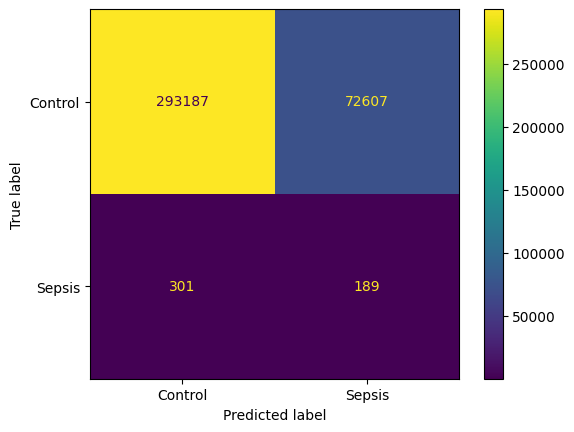

In [20]:
evaluation.plot_confusion_matrix(model)
evaluation.get_df_metrics(model)

## Maintain connection

In [ ]:
import time
def sleeper(minutes):
    for i in range(minutes):
        time.sleep(60)
        print("Still sleeping and waiting for you so you dont have to reconnect everything")
sleeper(60*24)